In [54]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date
from datetime import datetime

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve
import mean_rev_utl as mru

## Importing and processing data

In [55]:
#parameters
short = 20
long = 120

#inverse volatility parameters
window = 30 #days
estimator = 'stdv' #'eq_weight' #'satchell'
weighting = 'inverse_vol' #'vol' 


bonds_list = ['TLT', 'BND', 'TIP', 'PHB', 'BWX', 'VCSH', 'GBF', 
            'BSV', 'PLW', 'IGIB', 'IGSB', 'WIP', 'PWZ', 'CWB', 'SPTI'] #['TLT', 'BND', 'TIP', 'PHB', 'VCSH', 'BWX'] #['TLT', 'PHB', 'VCSH'] #['TLT', 'BND', 'TIP', 'PHB', 'VCSH'] # 'BWX'  #
commodities_list = ['DBB', 'GLD', 'SLV', 'PPLT', 'DBA', 'DBO', 'UNG', 
                    'CORN', 'SOYB', 'DBE', 'USO', 'UGA', 'GRU', 'GSG', 'FUE'] #['GLD', 'DBA', 'DBO', 'UNG', 'CORN', 'SLV', 'DBB', 'PPLT', 'SOYB']#['SLV', 'DBB', 'DBO', 'GLD'] #['DBB', 'GLD', 'DBA', 'DBO', 'UNG', 'CORN'] # 'SLV', 'PPLT', 'SOYB'  #
currencies_list = ['UUP', 'CYB', 'FXB', 'FXE', 'FXY', 'FXA', 'ULE', 'FXC',
               'FXF', 'CEW', 'USDU', 'EUO', 'YCL'] #'DVB', 'UND',['UUP', 'CYB', 'FXB', 'FXE', 'FXY'] #['CYB']  # # 

start_date = '2006-01-03'
end_date = "2020-11-26"

In [56]:
US_equity = pd.read_csv('../data/key_market_USequties.csv', index_col = 0, header = [0,1])
global_equity = pd.read_csv('../data/key_market_GLOBequties.csv', index_col = 0, header = [0,1])
bonds = pd.read_csv('../data/key_market_bonds.csv', index_col = 0, header = [0,1])
currencies = pd.read_csv('../data/key_market_currencies.csv', index_col = 0, header = [0,1])
commodities = pd.read_csv('../data/key_market_commodities.csv', index_col = 0, header = [0,1])
df_tot = pd.concat([bonds, currencies, commodities], axis = 1)
df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
df_close.columns = df_close.columns.droplevel(1)
data_tot = df_close[start_date:end_date] 

In [57]:
#compute unique names
title = ''
unique_name = 'MATS+' + weighting + estimator + '_bond_commodities_currencies_'
title += 'short '+ str(short) + ' long '+ str(long) + 'estimator: ' + estimator 
unique_name = unique_name + '_short_' + str(short) + '_long_'+ str(long)
title = 'Bond/Comm/Curr report'
#unique_name = 'all_75_etfs_stdv_inv_vol_weight'

### Bonds weighting

In [58]:
data = data_tot[bonds_list]
signal_df = mru.create_mean_rev_signal(data, long, short)[0]

df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

if estimator == 'stdv':    
    df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    if weighting == 'inverse_vol':
        inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
        df_weighted = hep.df_wheighted(inv_volat_data.fillna(0)) #normalize the rows for the weights
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_strd_dev.fillna(0)) #normalize the rows for the weights

df_weighted = df_weighted/2 #equal distribution of weights        
        
data_earnings = hep.df_earnings((signal_df * df_weighted), data_r.fillna(0))
#data_earnings.dropna(inplace = True)
data_earnings.index = pd.to_datetime(data_earnings.index)
data_earnings_bonds = data_earnings

### Commodities weighting

In [59]:
data = data_tot[commodities_list]
signal_df = mru.create_mean_rev_signal(data, long, short)[0]

df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

if estimator == 'stdv':    
    df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    if weighting == 'inverse_vol':
        inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
        df_weighted = hep.df_wheighted(inv_volat_data.fillna(0)) #normalize the rows for the weights
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_strd_dev.fillna(0)) #normalize the rows for the weights

df_weighted = df_weighted/4 #equal distribution of weights        

data_earnings = hep.df_earnings((signal_df * df_weighted), data_r.fillna(0))
#data_earnings.dropna(inplace = True)
data_earnings.index = pd.to_datetime(data_earnings.index)
data_earnings_commodities = data_earnings

### Currencies weighting

In [60]:
data = data_tot[currencies_list]
signal_df = mru.create_mean_rev_signal(data, long, short)[0]

df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

if estimator == 'stdv':    
    df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    if weighting == 'inverse_vol':
        inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
        df_weighted = hep.df_wheighted(inv_volat_data.fillna(0)) #normalize the rows for the weights
    if weighting == 'vol':
        df_weighted = hep.df_wheighted(df_strd_dev.fillna(0)) #normalize the rows for the weights

df_weighted = df_weighted/4 #equal distribution of weights        

data_earnings = hep.df_earnings((signal_df * df_weighted), data_r.fillna(0))
#data_earnings.dropna(inplace = True)
data_earnings.index = pd.to_datetime(data_earnings.index)
data_earnings_currencies = data_earnings

### Create total returns

In [61]:
data_earnings = pd.DataFrame()
data_earnings['Tot'] = data_earnings_bonds['Tot'] + data_earnings_commodities['Tot'] + data_earnings_currencies['Tot']

In [62]:
data_earnings[30:]

,Tot
Date,
2006-02-15,0.000000
2006-02-16,0.000000
2006-02-17,0.000000
2006-02-21,0.000000
2006-02-22,0.000000
...,...
2020-11-19,0.000456
2020-11-20,-0.000043
2020-11-23,-0.001077


## Report

In [63]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

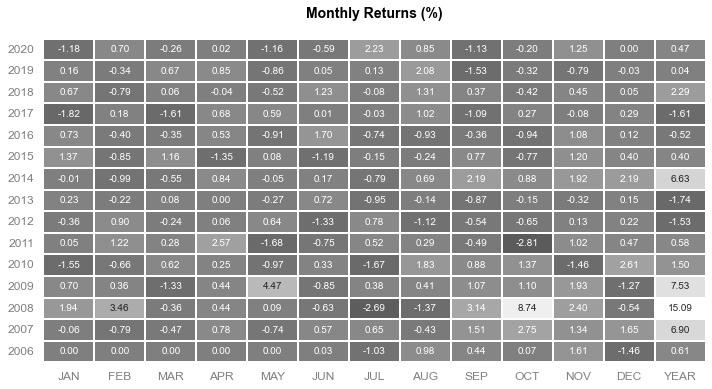

In [64]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

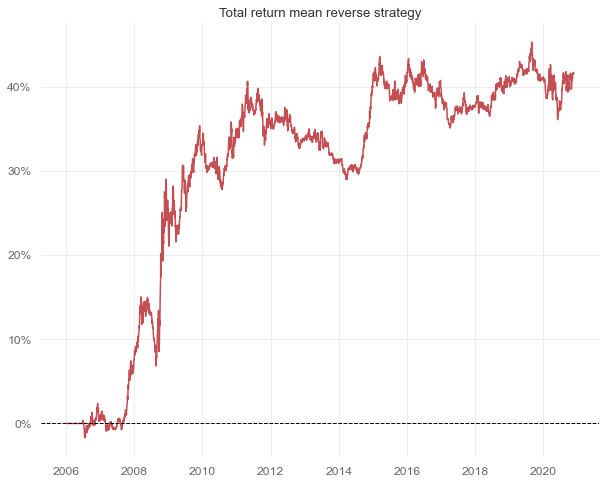

In [65]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/satchell_1x_leverage.png')

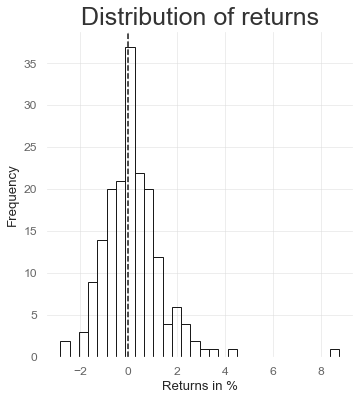

In [66]:
#### Distribution plot:

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

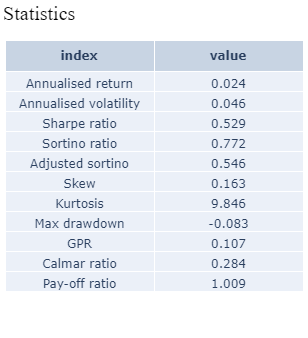

In [67]:
#### Table of statistics:

# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

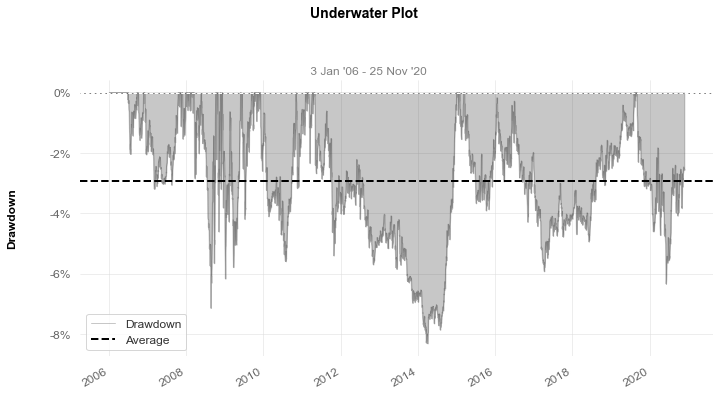

In [68]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

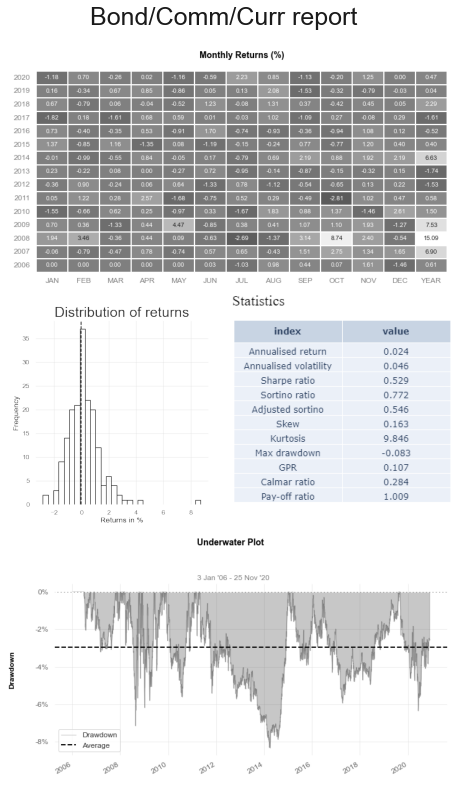

In [69]:
fig = plt.figure(figsize=(8, 13.55))
gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'k') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)

## Buy and hold strategy

In [70]:
data_r = data.div(data_tot.shift(1))-1 #returns of securities
buy_and_hold_returns = data_r.copy()
buy_and_hold_returns['Tot'] = buy_and_hold_returns.sum(axis= 1)
buy_and_hold_returns.index = pd.to_datetime(buy_and_hold_returns.index)
buy_and_hold_returns['n_sec_active'] = buy_and_hold_returns.drop(columns = ['Tot']).apply(mru.number_nan, axis = 1)
buy_and_hold_returns['Tot'] = buy_and_hold_returns['Tot']/buy_and_hold_returns['n_sec_active']
buy_and_hold_returns.drop(columns = ['n_sec_active'], inplace = True)
buy_and_hold_returns

,BND,BSV,BWX,CEW,CORN,CWB,CYB,DBA,DBB,DBE,...,ULE,UND,UNG,USDU,USO,UUP,VCSH,WIP,YCL,Tot
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009736
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002143
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004377
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,NaN,NaN,NaN,0.005531,NaN,NaN,-0.007701,NaN,NaN,NaN,...,0.003351,NaN,NaN,-0.000386,NaN,-0.001604,NaN,NaN,0.001686,0.000088
2020-11-20,NaN,NaN,NaN,-0.004951,NaN,NaN,0.005543,NaN,NaN,NaN,...,-0.004008,NaN,NaN,-0.003088,NaN,0.001205,NaN,NaN,-0.001010,-0.000391
2020-11-23,NaN,NaN,NaN,-0.003317,NaN,NaN,-0.004410,NaN,NaN,NaN,...,-0.000671,NaN,NaN,0.004259,NaN,0.001604,NaN,NaN,-0.013985,-0.002013


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-11-25  2020-11-25
Risk-Free Rate             0.0%        0.0%
Time in Market             97.0%       100.0%

Cumulative Return          41.63%      18.0%
CAGR﹪                     2.36%       1.12%

Sharpe                     0.53        0.27
Prob. Sharpe Ratio         97.96%      84.74%
Smart Sharpe               0.52        0.26
Sortino                    0.77        0.39
Smart Sortino              0.76        0.38
Sortino/√2                 0.55        0.27
Smart Sortino/√2           0.54        0.27
Omega                      1.11        1.11

Max Drawdown               -8.32%      -19.53%
Longest DD Days            1608        3404
Volatility (ann.)          4.62%       4.59%
R^2                        0.0         0.0
Information Ratio          0.01        0.01
Calmar                     0.28        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-05-02,2014-04-02,2015-01-02,1341,-8.317929,-8.049752
2,2008-03-17,2008-08-21,2008-10-06,203,-7.142731,-6.131312
3,2019-09-04,2020-06-05,2020-11-25,448,-6.341079,-5.819906
4,2008-12-08,2009-01-06,2009-05-29,172,-6.169224,-5.744803
5,2015-03-18,2017-04-10,2019-08-12,1608,-5.927626,-5.568226


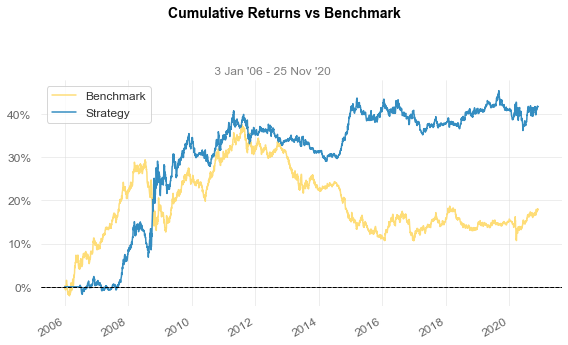

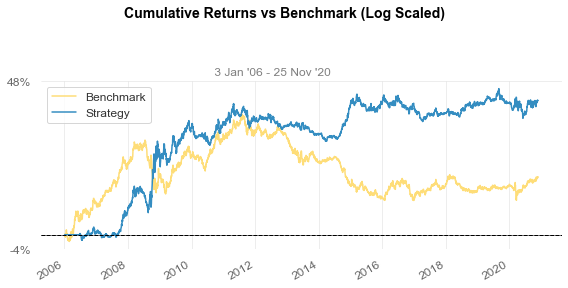

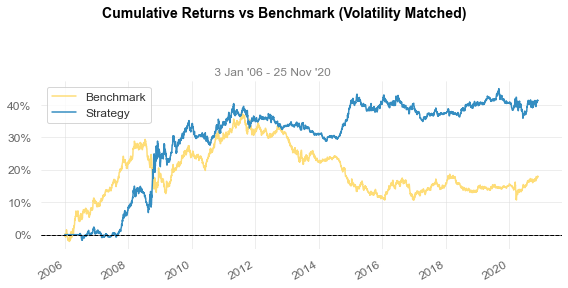

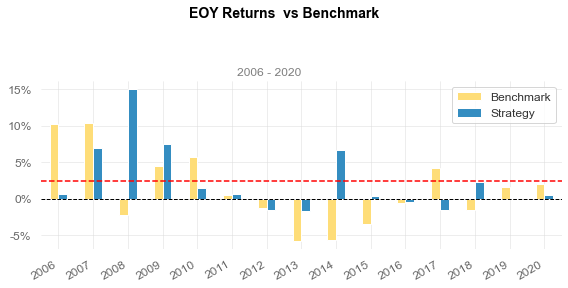

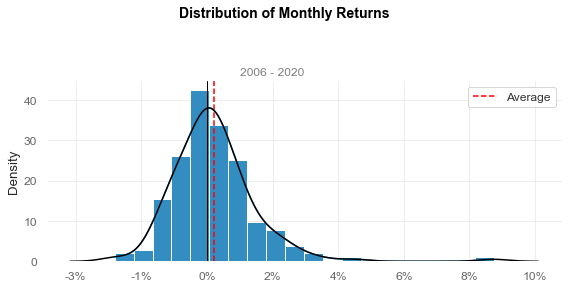

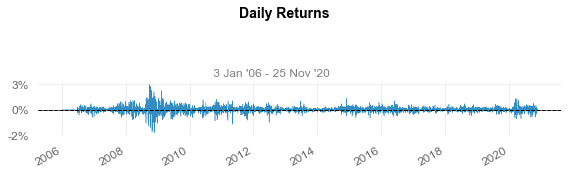

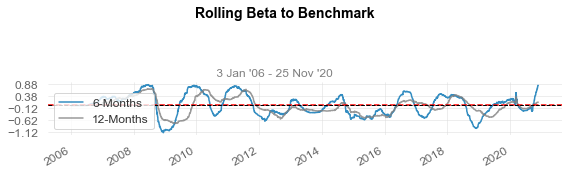

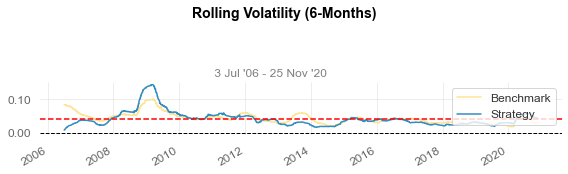

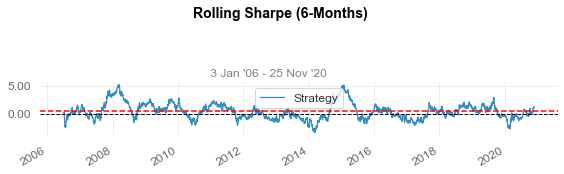

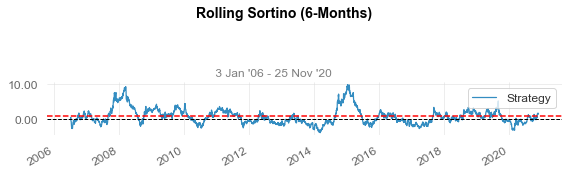

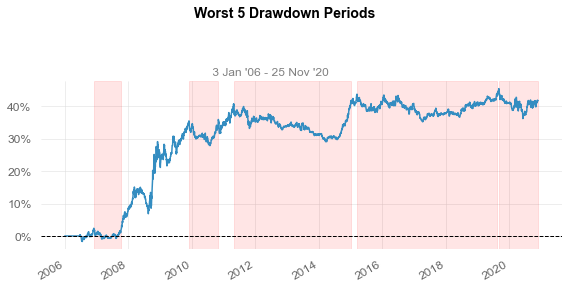

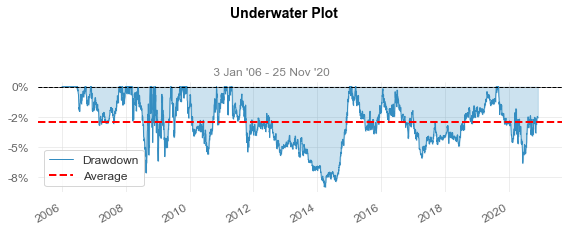

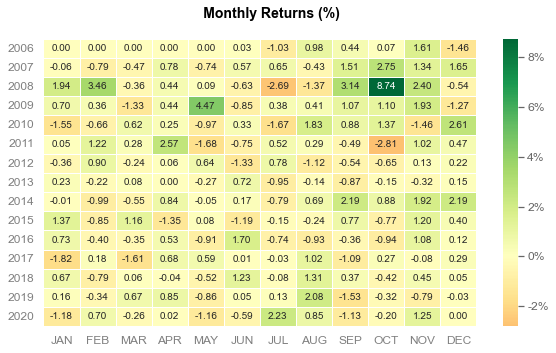

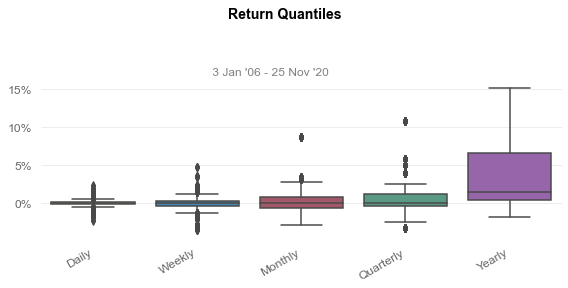

In [71]:
import quantstats as qs 

qs.reports.full(data_earnings['Tot'], benchmark = buy_and_hold_returns['Tot'])

In [72]:
currencies = currencies.iloc[:, currencies.columns.get_level_values(1)=='Close']
currencies.columns = currencies.columns.droplevel(1)

In [73]:
currencies['DVB'].dropna()[:100]

Date
2006-01-03    183.800003
2006-01-09    175.000000
2006-01-10    175.000000
2006-01-11    175.000000
2006-01-12    175.000000
                 ...    
2006-06-02    183.500000
2006-06-05    183.500000
2006-06-06    183.500000
2006-06-07    183.500000
2006-06-08    187.500000
Name: DVB, Length: 100, dtype: float64